In [1]:
# !python.exe -m pip install --upgrade pip
# !pip install tensorflow
# !pip install --upgrade imbalanced-learn
# !pip install xgboost

In [2]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import make_scorer, precision_score, roc_auc_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
from sklearn.utils import class_weight

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import tensorflow.keras.backend as K
from tensorflow.keras.metrics import Precision, AUC

import xgboost as xgb

from pymoo.core.problem import ElementwiseProblem
from pymoo.core.variable import Real, Integer, Choice, Binary
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.core.mixed import MixedVariableMating, MixedVariableSampling, \
    MixedVariableDuplicateElimination
from pymoo.core.problem import StarmapParallelization
from pymoo.optimize import minimize

RND_STATE = 37
NN_METRIC = AUC
TUNING_SCORER = roc_auc_score

# Read data

In [3]:
std_modeling = pd.read_csv('data/std_modeling.csv')
minmax_modeling = pd.read_csv('data/minmax_modeling.csv')

In [4]:
worth = std_modeling[std_modeling['worthy']==1]
not_worth = std_modeling[std_modeling['worthy']==0]
len(worth)

291

<Axes: >

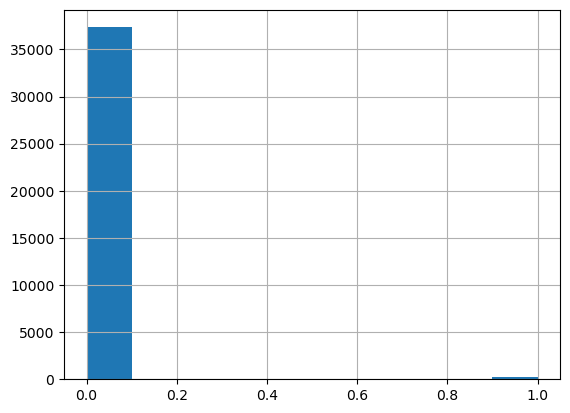

In [5]:
std_modeling['worthy'].hist()

In [6]:
X = std_modeling.drop(columns=['worthy'])
y = std_modeling['worthy']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((30112, 140), (7528, 140), (30112,), (7528,))

In [7]:
X_test

,priceNative,priceUsd,txns_m5_buys,txns_m5_sells,txns_h1_buys,txns_h1_sells,txns_h6_buys,txns_h6_sells,txns_h24_buy,txns_h24_sells,...,symbolVectorDim5,symbolVectorDim6,symbolVectorDim7,symbolVectorDim8,symbolVectorDim9,symbolVectorDim10,symbolVectorDim11,symbolVectorDim12,symbolVectorDim13,symbolVectorDim14
11191,-0.006355,-0.010264,-0.468977,-0.485292,-0.469023,-0.485300,-0.469023,-0.485300,-0.469023,-0.485300,...,0.761547,0.524396,0.726792,0.098313,-1.023680,0.498407,0.648949,0.578854,0.401894,0.314812
31459,-0.006355,-0.010264,-0.392297,-0.522432,-0.392344,-0.522439,-0.392344,-0.522439,-0.392344,-0.522439,...,-0.364335,0.192579,0.668788,0.892493,-1.329547,0.279472,0.526785,0.731895,0.872327,0.418628
5439,-0.006355,-0.010264,0.703135,-0.212935,0.703079,-0.212944,0.703079,-0.212944,0.703079,-0.212944,...,0.457530,-1.484375,-1.470133,-0.850370,0.254429,-1.375326,-1.287357,-1.707013,-1.400042,-1.792793
26706,-0.006355,-0.010264,-0.293708,-0.274834,-0.293756,-0.274843,-0.293756,-0.274843,-0.293756,-0.274843,...,0.552780,0.533501,1.264073,-0.056265,-0.350691,0.744568,0.474895,0.440980,0.546037,0.232204
3831,-0.006355,-0.010264,-0.458023,-0.522432,-0.458069,-0.522439,-0.458069,-0.522439,-0.458069,-0.522439,...,1.761564,-1.613059,-1.861109,-2.081607,2.235318,-1.724028,-1.722880,-1.857605,-1.664119,-1.915734
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2407,-0.006355,-0.010264,-0.096530,-0.398633,-0.096579,-0.398641,-0.096579,-0.398641,-0.096579,-0.398641,...,-2.129457,0.624092,0.569343,0.050512,-0.932951,1.037712,0.723431,0.328034,0.533042,0.585558
36241,-0.006355,-0.010264,-0.994785,-0.609091,-0.994826,-0.609098,-0.994826,-0.609098,-0.994826,-0.609098,...,1.024893,0.646818,0.954582,0.816249,0.066406,0.827066,0.479026,0.128275,0.235454,0.713210
10244,-0.006355,-0.010264,-0.545658,-0.460532,-0.545703,-0.460540,-0.545703,-0.460540,-0.545703,-0.460540,...,1.039228,0.551123,0.623247,0.407844,-0.763415,0.437252,0.539628,0.574956,0.494914,0.311946
5896,-0.006355,-0.010264,2.236741,0.802215,2.236672,0.802199,2.236672,0.802199,2.236672,0.802199,...,0.241895,-1.710223,-1.655571,-1.905440,0.930616,-1.300494,-1.694732,-1.364546,-1.272669,-1.529224


In [8]:
smote = SMOTE(random_state=None)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Dummy models

## Random Forest model (balanced)

In [9]:
# Inicjalizacja modelu Random Forest
rf_model = BalancedRandomForestClassifier(replacement=True,
                                          bootstrap=False,
                                          class_weight='balanced',
                                          sampling_strategy='all',
                                          n_jobs=-1)

# Trenowanie modelu na danych treningowych
rf_model.fit(X_train, y_train)

# Przewidywanie na zbiorze testowym
y_pred = rf_model.predict(X_test)
joblib.dump(rf_model, 'models/default_rf_model.joblib')


# Ocena modelu
_f1_score = f1_score(y_test, y_pred)
_precision = precision_score(y_test, y_pred)
_auc = roc_auc_score(y_test, y_pred)
print(f'SCORES: f1: {_f1_score:.4f}, prec: {_precision:.4f}, auc: {_auc:.4f}', end='\n\n')
# Dodatkowa ocena za pomocą classification report
report = classification_report(y_test, y_pred)
print(report)

SCORES: f1: 0.0367, prec: 0.0192, auc: 0.6300

              precision    recall  f1-score   support

         0.0       0.99      0.83      0.90      7470
         1.0       0.02      0.43      0.04        58

    accuracy                           0.83      7528
   macro avg       0.51      0.63      0.47      7528
weighted avg       0.99      0.83      0.90      7528



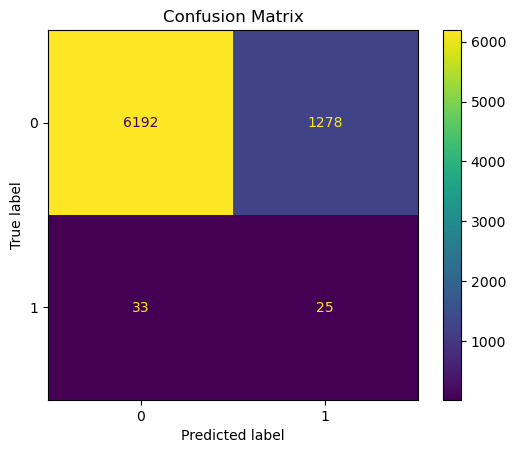

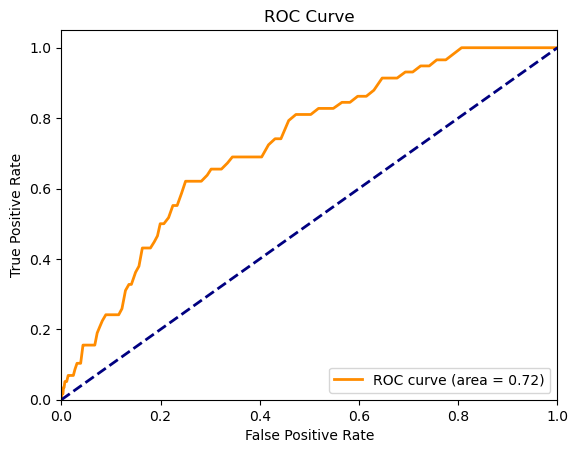

In [10]:
# Macierz pomyłek
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix")
plt.show()

# Krzywa ROC
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

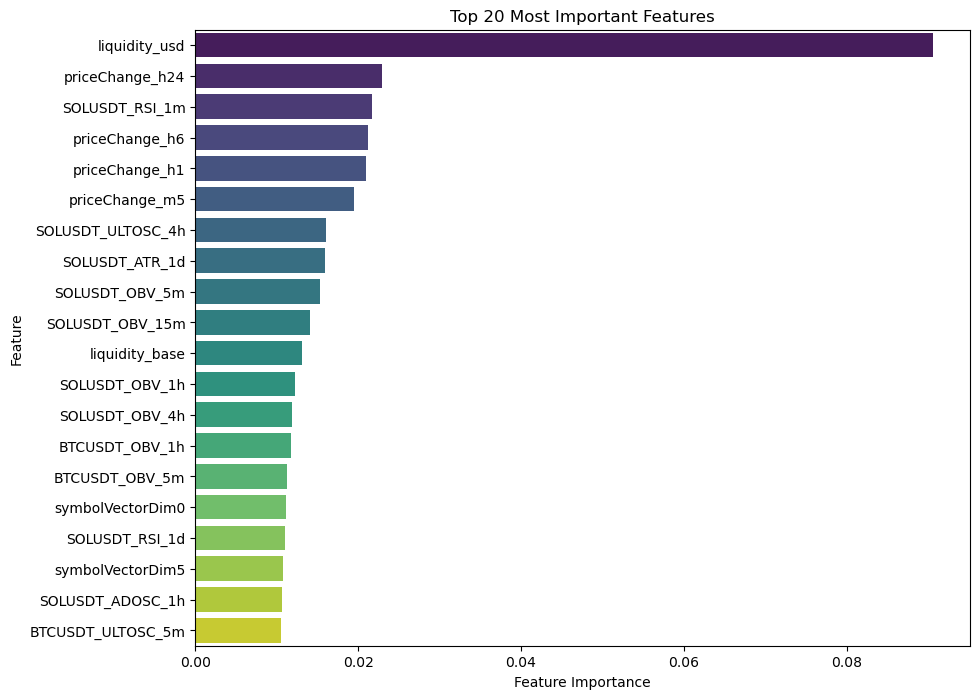

In [11]:
# Obliczanie średniej ważności cech
feature_importances = rf_model.estimators_[0].feature_importances_
for estimator in rf_model.estimators_[1:]:
    feature_importances += estimator.feature_importances_
feature_importances /= len(rf_model.estimators_)

# Tworzenie DataFrame z ważnościami cech
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

# Sortowanie cech według ważności
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Rysowanie wykresu ważności cech
plt.figure(figsize=(10, 8))
sns.barplot(data=feature_importance_df.head(20), x='Importance', y='Feature', palette='viridis')
plt.title('Top 20 Most Important Features')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.show()

## Logistic regression

In [12]:
lr_model = LogisticRegression(class_weight='balanced',  max_iter=10_000)
lr_model.fit(X_train_res, y_train_res)
joblib.dump(lr_model, 'models/default_lr_model.joblib')

# Dokonaj predykcji na zestawie testowym
y_pred = lr_model.predict(X_test)

_f1_score = f1_score(y_test, y_pred)
_precision = precision_score(y_test, y_pred)
_auc = roc_auc_score(y_test, y_pred)
print(f'SCORES: f1: {_f1_score:.4f}, prec: {_precision:.4f}, auc: {_auc:.4f}', end='\n\n')
print(classification_report(y_test, y_pred))

SCORES: f1: 0.0218, prec: 0.0112, auc: 0.5676

              precision    recall  f1-score   support

         0.0       0.99      0.70      0.82      7470
         1.0       0.01      0.43      0.02        58

    accuracy                           0.70      7528
   macro avg       0.50      0.57      0.42      7528
weighted avg       0.99      0.70      0.82      7528



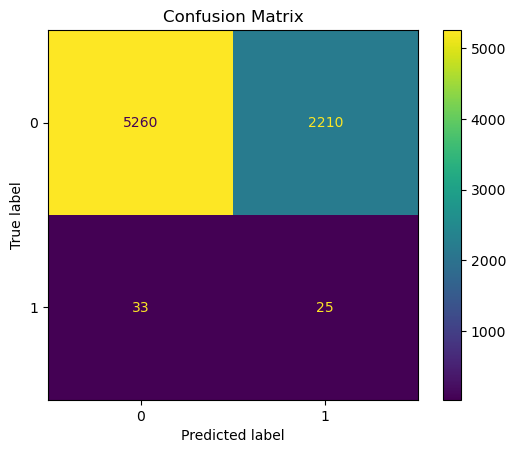

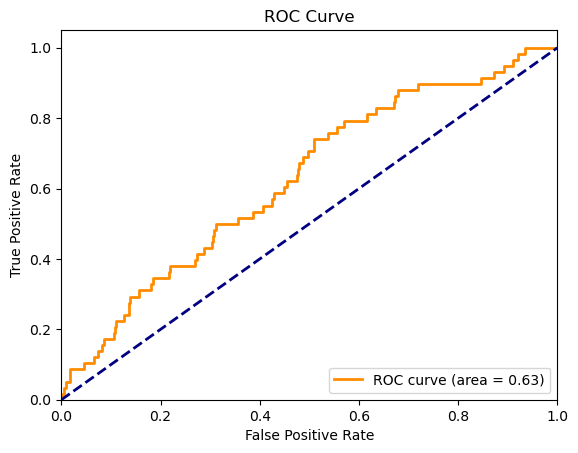

In [13]:
# Macierz pomyłek
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix")
plt.show()

# Krzywa ROC
y_pred_proba = lr_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

## XGBoost

In [14]:
gb_model = xgb.XGBClassifier(device='cuda')
gb_model.fit(X_train, y_train)
joblib.dump(gb_model, 'models/default_gb_model.joblib')

['models/default_gb_model.joblib']

In [15]:
y_pred = gb_model.predict(X_test)

_f1_score = f1_score(y_test, y_pred)
_precision = precision_score(y_test, y_pred)
_auc = roc_auc_score(y_test, y_pred)
print(f'SCORES: f1: {_f1_score:.4f}, prec: {_precision:.4f}, auc: {_auc:.4f}', end='\n\n')

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

SCORES: f1: 0.0339, prec: 1.0000, auc: 0.5086

[[7470    0]
 [  57    1]]
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00      7470
         1.0       1.00      0.02      0.03        58

    accuracy                           0.99      7528
   macro avg       1.00      0.51      0.52      7528
weighted avg       0.99      0.99      0.99      7528



C:\Users\philipz\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:20:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


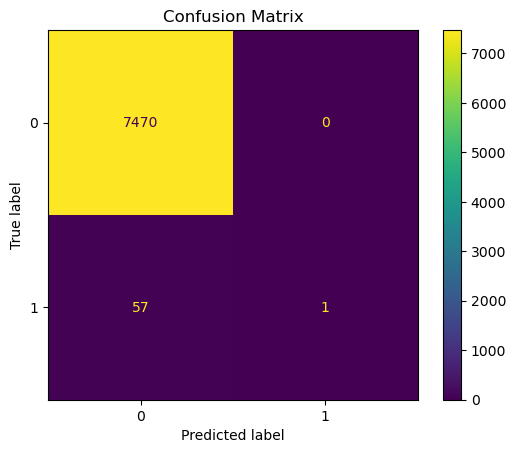

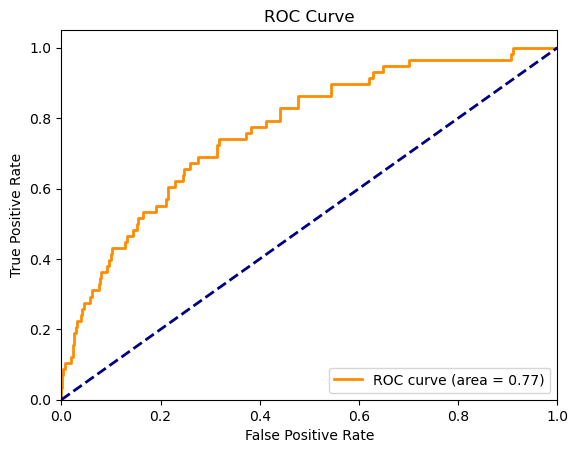

In [16]:
# Macierz pomyłek
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix")
plt.show()

# Krzywa ROC
y_pred_proba = gb_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

## SVM

In [17]:
# Trenuj model SVM
svm_model = SVC(C=1.0, kernel='rbf', class_weight='balanced', probability=True)
svm_model.fit(X_train, y_train)
joblib.dump(svm_model, 'models/default_svm_model.joblib')

# calibrated_svc = CalibratedClassifierCV(svm_model)
# calibrated_svc.fit(X_train, y_train)

# Dokonaj predykcji na zestawie testowym
y_pred = svm_model.predict(X_test)

_f1_score = f1_score(y_test, y_pred)
_precision = precision_score(y_test, y_pred)
_auc = roc_auc_score(y_test, y_pred)
print(f'SCORES: f1: {_f1_score:.4f}, prec: {_precision:.4f}, auc: {_auc:.4f}', end='\n\n')

print(classification_report(y_test, y_pred))

SCORES: f1: 0.0391, prec: 0.0221, auc: 0.5566

              precision    recall  f1-score   support

         0.0       0.99      0.94      0.97      7470
         1.0       0.02      0.17      0.04        58

    accuracy                           0.93      7528
   macro avg       0.51      0.56      0.50      7528
weighted avg       0.99      0.93      0.96      7528



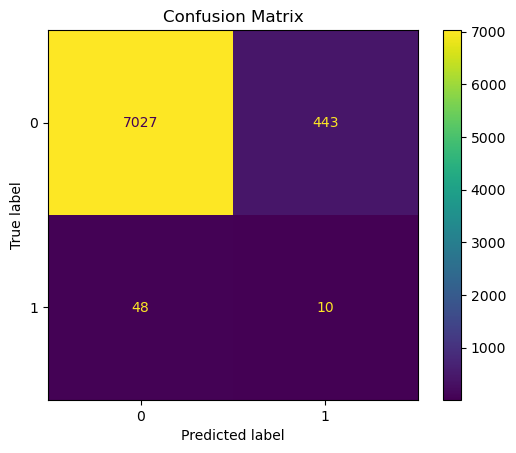

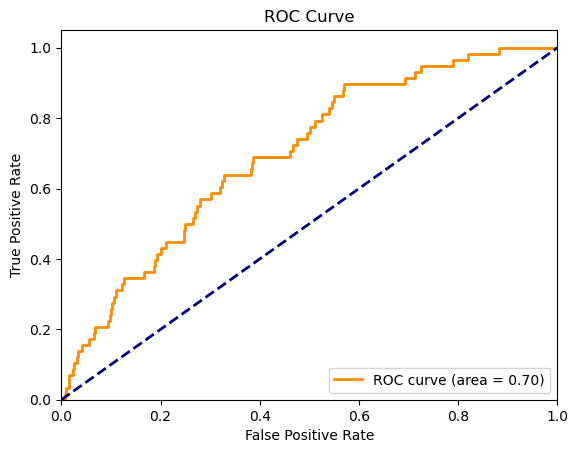

In [18]:
# Macierz pomyłek
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix")
plt.show()

# Krzywa ROC
y_pred_proba = svm_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

### Neural net model (not yet used)

In [19]:
def f1_score_K(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(K.round(y_pred), 'float32')
    
    tp = K.sum(y_true * y_pred, axis=0)
    fp = K.sum((1 - y_true) * y_pred, axis=0)
    fn = K.sum(y_true * (1 - y_pred), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2 * p * r / (p + r + K.epsilon())
    f1 = K.mean(f1)
    return f1

In [20]:
# Budowa modelu z użyciem Input
model = Sequential()
model.add(Input(shape=(X_train.shape[1],)))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

early_stopping = EarlyStopping(monitor='val_loss',
                               mode='min',
                               patience=10,
                               restore_best_weights=True)

# Kompilacja modelu
model.compile(optimizer=Adam(),
              loss='binary_crossentropy',
              metrics=[NN_METRIC()])

# Trenowanie modelu z użyciem class_weight
history = model.fit(X_train,
                    y_train,
                    epochs=250,
                    batch_size=8,
                    # class_weight=class_weights,
                    validation_split=0.1,
                    callbacks=early_stopping)

# Ewaluacja modelu
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy:.2f}')

y_pred = (model.predict(X_test) > 0.5).astype("int32")

_f1_score = f1_score(y_test, y_pred)
_precision = precision_score(y_test, y_pred)
_auc = roc_auc_score(y_test, y_pred)
print(f'SCORES: f1: {_f1_score:.4f}, prec: {_precision:.4f}, auc: {_auc:.4f}', end='\n\n')

print("Classification Report:")
print(classification_report(y_test, y_pred))

Epoch 1/250
3388/3388 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - auc: 0.5297 - loss: 0.0565 - val_auc: 0.5506 - val_loss: 0.0563
Epoch 2/250
3388/3388 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - auc: 0.6222 - loss: 0.0455 - val_auc: 0.4984 - val_loss: 0.0900
Epoch 3/250
3388/3388 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - auc: 0.6793 - loss: 0.0455 - val_auc: 0.5939 - val_loss: 0.0577
Epoch 4/250
3388/3388 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - auc: 0.7138 - loss: 0.0480 - val_auc: 0.6297 - val_loss: 0.0562
Epoch 5/250
3388/3388 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - auc: 0.7384 - loss: 0.0447 - val_auc: 0.5691 - val_loss: 0.0579
Epoch 6/250
3388/3388 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - auc: 0.7326 - loss: 0.0411 - val_auc: 0.6044 - val_loss: 0.0584
Epoch 7/250
3388/3388 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - auc: 0.7895 - loss: 0.0376 - val_auc: 0.6110 - val_loss: 0.0575
Epoch 8/250
3388/3388 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - auc: 0.7933 - loss: 0.0401 - val_auc: 0.6136 - val_loss: 0.0603
Epoch 9/250
3388/3388 ━━━━━━━━━━

C:\Users\philipz\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\philipz\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\philipz\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\philipz\anaconda3\Lib\site-packag

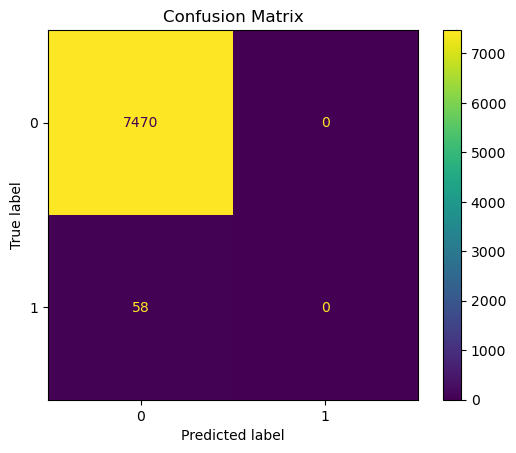

236/236 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step


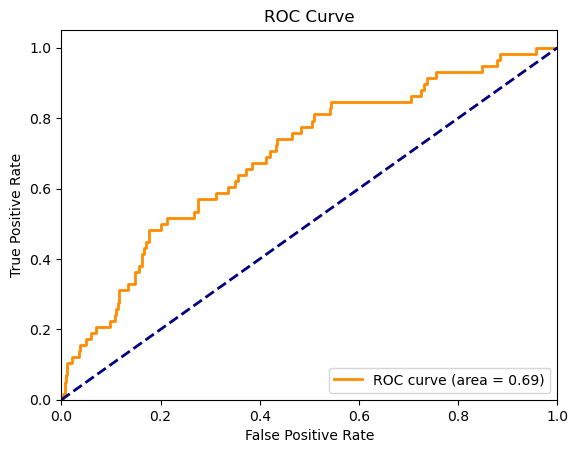

In [21]:
# Macierz pomyłek
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix")
plt.show()

# Krzywa ROC
y_pred_proba = model.predict(X_test)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [22]:
# Definicja metryki f1_score jako funkcji w Keras
def f1_m(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(K.round(y_pred), 'float32')
    def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# Budowa modelu z użyciem Input
model = Sequential()
model.add(Input(shape=(X_train.shape[1],)))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Kompilacja modelu
model.compile(optimizer=Adam(),
              loss='binary_crossentropy',
              metrics=[NN_METRIC()])

# Definicja EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss',
                               mode='min',
                               patience=10,
                               restore_best_weights=True)

# Trenowanie modelu z użyciem class_weight
history = model.fit(X_train,
                    y_train,
                    epochs=250,
                    batch_size=8, 
                    # class_weight=class_weights,
                    validation_split=0.1,
                    callbacks=[early_stopping]
                   )

# Ewaluacja modelu
loss, f1 = model.evaluate(X_test, y_test)
print(f'Test F1 Score: {f1:.2f}')

y_pred = (model.predict(X_test) > 0.5).astype("int32")

_f1_score = f1_score(y_test, y_pred)
_precision = precision_score(y_test, y_pred)
_auc = roc_auc_score(y_test, y_pred)
print(f'SCORES: f1: {_f1_score:.4f}, prec: {_precision:.4f}, auc: {_auc:.4f}', end='\n\n')

print("Classification Report:")
print(classification_report(y_test, y_pred))

Epoch 1/250
3388/3388 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - auc_1: 0.5426 - loss: 0.0664 - val_auc_1: 0.6146 - val_loss: 0.0562
Epoch 2/250
3388/3388 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - auc_1: 0.6412 - loss: 0.0434 - val_auc_1: 0.6292 - val_loss: 0.0533
Epoch 3/250
3388/3388 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - auc_1: 0.6437 - loss: 0.0446 - val_auc_1: 0.6644 - val_loss: 0.0569
Epoch 4/250
3388/3388 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - auc_1: 0.7212 - loss: 0.0487 - val_auc_1: 0.5629 - val_loss: 0.0634
Epoch 5/250
3388/3388 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - auc_1: 0.7062 - loss: 0.0427 - val_auc_1: 0.6342 - val_loss: 0.0559
Epoch 6/250
3388/3388 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - auc_1: 0.7374 - loss: 0.0403 - val_auc_1: 0.6347 - val_loss: 0.0544
Epoch 7/250
3388/3388 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - auc_1: 0.7568 - loss: 0.0427 - val_auc_1: 0.6414 - val_loss: 0.0626
Epoch 8/250
3388/3388 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - auc_1: 0.7752 - loss: 0.0473 - val_auc_1: 0.6796 - val_loss: 0.0606


C:\Users\philipz\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\philipz\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\philipz\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\philipz\anaconda3\Lib\site-packag

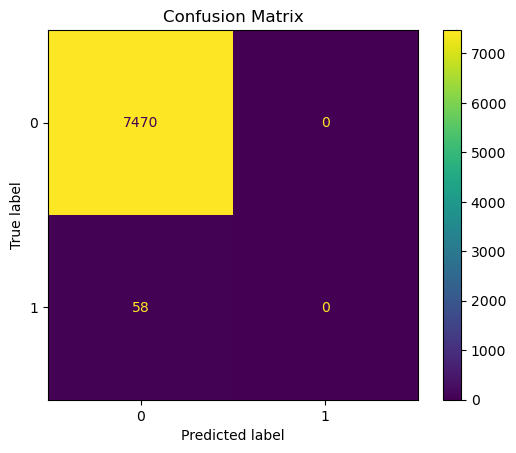

236/236 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


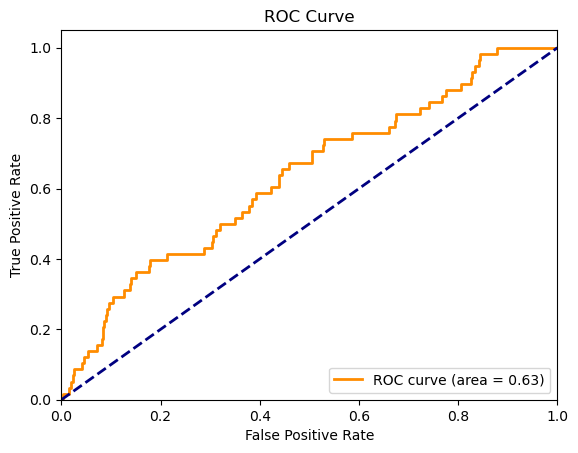

In [23]:
# Macierz pomyłek
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix")
plt.show()

# Krzywa ROC
y_pred_proba = model.predict(X_test)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

# Hiperparameter optimization

## Random Forest

In [24]:
class RFMixedVariableProblem(ElementwiseProblem):
    def __init__(self, x_data, y_data, cv_folds=5, rnd_state=None, **kwargs):
        self.x_data = x_data
        self.y_data = y_data
        self.cv_folds = cv_folds
        self.rnd_state = rnd_state
        
        self.skf = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=rnd_state)
        self.scorer = make_scorer(TUNING_SCORER)
        hyperparameters = {
            "n_estimators": Integer(bounds=(1, 500)),
            "criterion": Choice(options=["gini", "entropy"]),
            "max_depth": Integer(bounds=(1, 200)),
            "min_samples_split": Real(bounds=(.0, 1.0)),
            "min_samples_leaf": Real(bounds=(.0, 1.0)),
            "min_weight_fraction_leaf": Real(bounds=(.0, .5)),
            "max_features": Real(bounds=(0.001, 1.000)),
            "max_leaf_nodes": Integer(bounds=(2, 200)),
            "min_impurity_decrease": Real(bounds=(.0, 1.5)),
            "class_weight": Choice(options=["balanced", "balanced_subsample", None]),
            # "bootstrap": Binary(),
            # "oob_score": Binary(),
            # "warm_start": Binary(),
            # # "ccp_alpha": Real(bounds=(0.0, 10.0)),
            # "max_samples": Real(bounds=(0.001, 1.000)),
            # "monotonic_cst": Choice(options=[1, 0, -1, None])
        }
        super().__init__(vars=hyperparameters, n_obj=1, **kwargs)

    def _evaluate(self, X, out, *args, **kwargs):
        brf = BalancedRandomForestClassifier(n_jobs=-1, sampling_strategy='all', replacement=False, random_state=self.rnd_state,
            n_estimators=X['n_estimators'],
            criterion=X['criterion'],
            max_depth=X['max_depth'],
            min_samples_split=X['min_samples_split'],
            min_samples_leaf=X['min_samples_leaf'],
            min_weight_fraction_leaf=X['min_weight_fraction_leaf'],
            max_features=X['max_features'],
            max_leaf_nodes=X['max_leaf_nodes'],
            min_impurity_decrease=X['min_impurity_decrease'],
            class_weight=X['class_weight'],
            # bootstrap=X['bootstrap'],
            # oob_score=X['oob_score'] if X['bootstrap'] else False,
            # warm_start=X['warm_start'],
            # class_weight=X['class_weight'] if not X['warm_start'] else None,
            # # ccp_alpha=X['ccp_alpha'],
            # max_samples=None if not X['bootstrap'] else X['max_samples'],
            # monotonic_cst=X['monotonic_cst']
        )
        cv_scores = cross_val_score(brf, self.x_data, self.y_data, cv=self.skf, scoring=self.scorer, n_jobs=-1)
        mean_precision = np.mean(cv_scores)
        print(f'X: {X}')
        print(f'{self.cv_folds} folds cross-validated mean score: {mean_precision}', end='\n\n')
        out["F"] = -mean_precision

In [ ]:
# pool = Pool(cpu_count())
# runner = StarmapParallelization(pool.starmap)

problem = RFMixedVariableProblem(X_train, y_train, cv_folds=4, rnd_state=None)
algorithm = GA(pop_size=64,
               sampling=MixedVariableSampling(),
               mating=MixedVariableMating(eliminate_duplicates=MixedVariableDuplicateElimination()),
               eliminate_duplicates=MixedVariableDuplicateElimination())

res = minimize(problem,
               algorithm,
               termination=("time", "09:00:00"),
               # termination=("n_gen", 50),
               verbose=True)

X: {'n_estimators': 193, 'criterion': 'gini', 'max_depth': 168, 'min_samples_split': 0.47612065340506105, 'min_samples_leaf': 0.4274883096586537, 'min_weight_fraction_leaf': 0.21230122511902172, 'max_features': 0.2729589266410943, 'max_leaf_nodes': 58, 'min_impurity_decrease': 0.7603063317483489, 'class_weight': 'balanced_subsample'}
4 folds cross-validated mean score: 0.5

X: {'n_estimators': 222, 'criterion': 'entropy', 'max_depth': 67, 'min_samples_split': 0.4878315980553255, 'min_samples_leaf': 0.2261171010419969, 'min_weight_fraction_leaf': 0.4879128037344939, 'max_features': 0.7101343958574594, 'max_leaf_nodes': 190, 'min_impurity_decrease': 1.313194247671304, 'class_weight': None}
4 folds cross-validated mean score: 0.5

X: {'n_estimators': 451, 'criterion': 'gini', 'max_depth': 177, 'min_samples_split': 0.287179494203345, 'min_samples_leaf': 0.152856309438953, 'min_weight_fraction_leaf': 0.4664392183464475, 'max_features': 0.6501101043771483, 'max_leaf_nodes': 170, 'min_impurit

In [ ]:
if len(res.F) == 1:
    if isinstance(res.X, dict):
        print(f'Best gene: reward= {-res.f} variables= {list(res.X.values())}')
    else:
        print(f'Best gene: reward= {-res.f} variables= {res.X}')
else:
    print('Pareto front:')
    for front, var in zip(res.F, res.X):
        print(f"front=", front, "variables=", list(var.values()))

In [ ]:
# Inicjalizacja modelu Random Forest
rf_model = BalancedRandomForestClassifier(n_jobs=-1, replacement=True, sampling_strategy='all',
                                  random_state=None,
                                  n_estimators=246,
                                  max_depth=156,
                                  max_leaf_nodes=24,
                                  criterion='gini',
                                  class_weight=None,
                                  min_samples_split=0.09369105882160408,
                                  min_samples_leaf=0.02751719540215013,
                                  min_weight_fraction_leaf=0.045328246137509784,
                                  max_features=0.8037848114419907,
                                  min_impurity_decrease=0.8037848114419907,
                                  # bootstrap=False,
                                  # oob_score=False,
                                  # warm_start=False
                                 )

# Trenowanie modelu na danych treningowych
rf_model.fit(X_train, y_train)

# Przewidywanie na zbiorze testowym
y_pred = rf_model.predict(X_test)
joblib.dump(rf_model, 'models/tuned_rf_model.joblib')

# Ocena modelu
accuracy = f1_score(y_test, y_pred)
print(f'Score: {accuracy}')

# Dodatkowa ocena za pomocą classification report
report = classification_report(y_test, y_pred)
print(report)

In [ ]:
# Macierz pomyłek
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix")
plt.show()

# Krzywa ROC
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Obliczanie średniej ważności cech
feature_importances = rf_model.estimators_[0].feature_importances_
for estimator in rf_model.estimators_[1:]:
    feature_importances += estimator.feature_importances_
feature_importances /= len(rf_model.estimators_)

# Tworzenie DataFrame z ważnościami cech
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

# Sortowanie cech według ważności
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Rysowanie wykresu ważności cech
plt.figure(figsize=(10, 8))
sns.barplot(data=feature_importance_df.head(20), x='Importance', y='Feature', palette='viridis')
plt.title('Top 20 Most Important Features')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.show()

## SVM

In [ ]:
class SVMMixedVariableProblem(ElementwiseProblem):
    def __init__(self, x_data, y_data, cv_folds=5, n_estimators=4, rnd_state=None, **kwargs):
        self.x_data = x_data
        self.y_data = y_data
        self.cv_folds = cv_folds
        self.rnd_state = rnd_state
        self.n_estimators = n_estimators
        
        self.skf = StratifiedKFold(n_splits=cv_folds, shuffle=False, random_state=rnd_state)
        self.scorer = make_scorer(TUNING_SCORER)
        hyperparameters = {
            "C": Real(bounds=(0.0001, 10_000.0)),
            "kernel": Choice(options=["linear", "poly", "rbf", "sigmoid"]),
            "degree": Integer(bounds=(2, 15)),
            # "gamma": Choice(options=["scale", "auto"]),
            "gamma": Real(bounds=(.0001, 1.)), # causes problems with model
            "coef0": Real(bounds=(-15.0, 15.0)),
            "shrinking": Binary(),
            # "probability": Binary(), # False calculates faster
            # "tol": Real(bounds=(0.0001, 0.01)), # all models should have equal
            # "cache_size": Integer(bounds=(200, 1000)),
            # "class_weight": Choice(options=["balanced", None]),
            # "max_iter": Integer(bounds=(-1, 1000))
        }
        super().__init__(vars=hyperparameters, n_obj=1, **kwargs)

    def _evaluate(self, X, out, *args, **kwargs):
        # print(X)
        try:
            svm = SVC(max_iter=50,
                      class_weight='balanced',
                      probability=False,
                      C=X['C'],
                      kernel=X['kernel'],
                      degree=X['degree'],
                      gamma=X['gamma'],
                      coef0=X['coef0'],
                      shrinking=bool(X['shrinking']),
                      # probability=bool(X['probability']),
                      # tol=X['tol'], # stopping criterion, may cause troubles
                      # cache_size=X['cache_size'],
                      # class_weight=X['class_weight'],
                      # max_iter=X['max_iter']
                     )
            # b_svc= BaggingClassifier(svm,
            #                          max_samples=1.0 / self.n_estimators,
            #                          n_estimators=self.n_estimators,
            #                          n_jobs=-1)
            cv_scores = cross_val_score(svm,
                                        self.x_data,
                                        self.y_data,
                                        cv=self.skf,
                                        scoring=self.scorer,
                                        error_score='raise', n_jobs=-1)
            mean_f1 = np.mean(cv_scores)
            print(f'X: {X}')
            print(f'{self.cv_folds} folds cross-validated mean score: {mean_f1}', end='\n\n')
            out["F"] = -mean_f1
        except Exception as e:
            print(e)
            print('!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!')
            print(f'Model failure with prameters: {X}')
            print(f'{self.cv_folds} folds cross-validated mean score: -{np.inf}', end='\n\n')
            out["F"] = np.inf
            # raise e

In [ ]:
# pool = Pool(cpu_count())
# runner = StarmapParallelization(pool.starmap)

problem = SVMMixedVariableProblem(X_train, y_train, cv_folds=4, n_estimators=4, rnd_state=None)
algorithm = GA(pop_size=128,
               sampling=MixedVariableSampling(),
               mating=MixedVariableMating(eliminate_duplicates=MixedVariableDuplicateElimination()),
               eliminate_duplicates=MixedVariableDuplicateElimination())

res = minimize(problem,
               algorithm,
               termination=("time", "08:00:00"),
               # termination=("n_gen", 50),
               verbose=True)

In [ ]:
if len(res.F) == 1:
    if isinstance(res.X, dict):
        print(f'Best gene: reward= {-res.f} variables= {res.X.items()}')
    else:
        print(f'Best gene: reward= {-res.f} variables= {res.X}')
else:
    print('Pareto front:')
    for front, var in zip(res.F, res.X):
        print(f"front=", front, "variables=", list(var.values()))

In [ ]:
# Trenuj model SVM

svm_model = SVC(max_iter=-1,
                C=8149.480638948695,
                coef0=-13.40974924059736,
                # tol=0.007392566629174455,
                kernel='rbf',
                gamma=0.028951614538558074,
                class_weight='balanced',
                degree=15,
                shrinking=False,
                probability=True)

# n_estimators = 4
# b_svc= BaggingClassifier(svm_model, max_samples=1.0 / n_estimators, n_estimators=n_estimators, n_jobs=-1)
# b_svc.fit(X_train, y_train)

svm_model.fit(X_train_res, y_train_res)
joblib.dump(svm_model, 'models/tuned_svm_model.joblib')

# calibrated_svc = CalibratedClassifierCV(svm_model)
# calibrated_svc.fit(X_train, y_train)

y_pred = svm_model.predict(X_test)

score = f1_score(y_test, y_pred)
print(f'Score: {score}')

print(classification_report(y_test, y_pred))

In [ ]:
# Macierz pomyłek
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix")
plt.show()

# Krzywa ROC
y_pred_proba = svm_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

## Logistic regression

In [ ]:
class LogisticRegressionOptimizationProblem(ElementwiseProblem):
    def __init__(self, x_data, y_data, cv_folds=5, rnd_state=None, **kwargs):
        self.x_data = x_data
        self.y_data = y_data
        self.cv_folds = cv_folds
        self.rnd_state = rnd_state

        self.skf = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=rnd_state)
        self.scorer = make_scorer(TUNING_SCORER)
        
        hyperparameters = {
            "penalty": Choice(options=["l1", "l2", "elasticnet", None]),
            "dual": Binary(),
            "C": Real(bounds=(0.0001, 10_000.0)),
            "fit_intercept": Binary(),
            "intercept_scaling":Real(bounds=(0.01, 100.0)),
            "solver": Choice(options=["newton-cg", "newton-cholesky", "lbfgs", "liblinear", "sag", "saga"]),
            # "max_iter": Integer(bounds=(50, 1000)),
            "l1_ratio": Real(bounds=(0.0, 1.0))  # Only used if penalty is 'elasticnet'
        }
        super().__init__(vars=hyperparameters, n_obj=1, **kwargs)

    def _evaluate(self, X, out, *args, **kwargs):
        if X['solver'] in ['sag', 'newton-cg', 'newton-cholesky', 'lbfgs'] and X['penalty'] != ['l2']:
            X['penalty'] = None

        if X['solver']=='liblinear' and X['penalty'] not in ['l1', 'l2']:
            X['penalty'] = 'l1'

        print(f'X: {X}')
        lr = LogisticRegression(class_weight='balanced', max_iter=25,
                                penalty=X['penalty'],
                                dual=X['dual'] if X['penalty']=='l2' and X['solver']=='liblinear' else False,
                                C=X['C'],
                                fit_intercept=X['fit_intercept'],
                                intercept_scaling=X['intercept_scaling'],
                                solver=X['solver'],
                                l1_ratio=X['l1_ratio'],
                                random_state=self.rnd_state,
                                n_jobs=-1
                               )
        cv_scores = cross_val_score(lr, self.x_data, self.y_data, cv=self.skf, scoring=self.scorer, n_jobs=-1)
        mean_f1_score = np.mean(cv_scores)
        print(f'{self.cv_folds} folds cross-validated mean score: {mean_f1_score}', end='\n\n')
        
        out["F"] = -mean_f1_score

In [ ]:
# pool = Pool(cpu_count())
# runner = StarmapParallelization(pool.starmap)

problem = LogisticRegressionOptimizationProblem(X_train, y_train, cv_folds=4, rnd_state=None)
algorithm = GA(pop_size=64,
               sampling=MixedVariableSampling(),
               mating=MixedVariableMating(eliminate_duplicates=MixedVariableDuplicateElimination()),
               eliminate_duplicates=MixedVariableDuplicateElimination())

res = minimize(problem,
               algorithm,
               termination=("time", "02:00:00"),
               # termination=("n_gen", 50),
               verbose=True)

In [ ]:
if len(res.F) == 1:
    if isinstance(res.X, dict):
        print(f'Best gene: reward= {-res.f} variables= {res.X.items()}')
    else:
        print(f'Best gene: reward= {-res.f} variables= {res.X}')
else:
    print('Pareto front:')
    for front, var in zip(res.F, res.X):
        print(f"front=", front, "variables=", list(var.values()))

In [ ]:
lr_model = LogisticRegression(class_weight='balanced', max_iter=100,
                              penalty=None,
                              dual=False,
                              C=4423.784376916033,
                              fit_intercept=True,
                              intercept_scaling=16.272085547573752,
                              solver='newton-cholesky',
                              l1_ratio=0.8360826053419824,
                              # random_state=RND_STATE,
                              n_jobs=-1
                             )
lr_model.fit(X_train_res, y_train_res)
joblib.dump(lr_model, 'models/tuned_lr_model.joblib')

# Dokonaj predykcji na zestawie testowym
y_pred = lr_model.predict(X_test)

score = f1_score(y_test, y_pred)
print(f'Score: {score}')

print(classification_report(y_test, y_pred))

In [ ]:
# Macierz pomyłek
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix")
plt.show()

# Krzywa ROC
y_pred_proba = lr_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

## XGBoost

In [ ]:
class GradientBoostingOptimizationProblem(ElementwiseProblem):
    def __init__(self, x_data, y_data, cv_folds=5, rnd_state=None, **kwargs):
        self.x_data = x_data
        self.y_data = y_data
        self.cv_folds = cv_folds
        self.rnd_state = rnd_state

        self.skf = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=rnd_state)
        self.scorer = make_scorer(TUNING_SCORER)
        
        hyperparameters = {
            "loss": Choice(options=["log_loss", "exponential"]),
            "learning_rate": Real(bounds=(0.001, 1000.0)),
            "n_estimators": Integer(bounds=(5, 500)),
            "subsample": Real(bounds=(0.01, 1.0)),
            "criterion": Choice(options=["friedman_mse", "squared_error"]),
            "min_samples_split": Real(bounds=(0.001, 1.0)),
            "min_samples_leaf": Real(bounds=(0.001, 1.0)),
            "min_weight_fraction_leaf": Real(bounds=(0.0, 0.5)),
            "max_depth": Integer(bounds=(1, 100)),
            "min_impurity_decrease": Real(bounds=(0.0, 100.0)),
            "max_features": Choice(options=["sqrt", "log2", None]),
            "max_leaf_nodes": Integer(bounds=(2, 100), strict=False),
            "validation_fraction": Real(bounds=(0.01, 0.5))
        }
        super().__init__(vars=hyperparameters, n_obj=1, **kwargs)

    def _evaluate(self, X, out, *args, **kwargs):
        print(f'X: {X}')
        gbc = GradientBoostingClassifier(
            loss=X['loss'],
            learning_rate=X['learning_rate'],
            n_estimators=X['n_estimators'],
            subsample=X['subsample'],
            criterion=X['criterion'],
            min_samples_split=X['min_samples_split'],
            min_samples_leaf=X['min_samples_leaf'],
            min_weight_fraction_leaf=X['min_weight_fraction_leaf'],
            max_depth=X['max_depth'],
            min_impurity_decrease=X['min_impurity_decrease'],
            max_features=X['max_features'],
            max_leaf_nodes=X['max_leaf_nodes'],
            validation_fraction=X['validation_fraction'],
            random_state=self.rnd_state
        )
        
        cv_scores = cross_val_score(gbc, self.x_data, self.y_data, cv=self.skf, scoring=self.scorer, n_jobs=-1)
        mean_f1_score = np.mean(cv_scores)
        print(f'{self.cv_folds} folds cross-validated mean score: {mean_f1_score}', end='\n\n')
        
        out["F"] = -mean_f1_score

In [ ]:
# pool = Pool(cpu_count())
# runner = StarmapParallelization(pool.starmap)

problem = GradientBoostingOptimizationProblem(X_train, y_train, cv_folds=4, rnd_state=None)
algorithm = GA(pop_size=64,
               sampling=MixedVariableSampling(),
               mating=MixedVariableMating(eliminate_duplicates=MixedVariableDuplicateElimination()),
               eliminate_duplicates=MixedVariableDuplicateElimination())

res = minimize(problem,
               algorithm,
               termination=("time", "02:00:00"),
               # termination=("n_gen", 50),
               verbose=True)

In [ ]:
# scores = []
# for i in range(2, 25):
#   kmeans = KMeans(n_clusters=i)
#   clusters = kmeans.fit_predict(std_modeling.drop(columns=['worthy']))

#   # Ewaluacja klastrów
#   score = silhouette_score(std_modeling, clusters)
#   print(f"k={i} Silhouette Score: {score}")
#   scores.append(score)

In [ ]:
# from tensorflow.keras import callbacks, regularizers
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
# from tensorflow.keras.optimizers import Adam
# from keras_tuner import HyperModel, Objective
# from keras_tuner.tuners import BayesianOptimization

# from datetime import datetime

# class MyHyperModel(HyperModel):
#     def __init__(self, input_shape):
#         self.input_shape = input_shape

#     def build(self, hp):
#         model = Sequential()
#         # Pierwsza warstwa Dense
#         model.add(Dense(units=hp.Int('units_input', min_value=8, max_value=256, step=8),
#                         activation=hp.Choice('activation_input', ['relu', 'elu']),
#                         kernel_regularizer=regularizers.l2(hp.Float('l2_input', min_value=1e-5, max_value=1e-1)),
#                         input_shape=(self.input_shape,)))

#         # Opcjonalna warstwa BatchNormalization po pierwszej warstwie Dense
#         if hp.Boolean('batch_norm_input'):
#             model.add(BatchNormalization())

#         # Opcjonalna warstwa Dropout po pierwszej warstwie Dense
#         if hp.Boolean('dropout_input'):
#             model.add(Dropout(rate=hp.Float('dropout_input_rate', min_value=0.0, max_value=0.75, step=0.05)))

#         # Dodatkowe warstwy Dense
#         for i in range(hp.Int('num_layers', 1, 8)):
#             model.add(Dense(units=hp.Int(f'units_layer_{i}', min_value=16, max_value=256, step=16),
#                             activation=hp.Choice(f'activation_{i}', ['relu', 'elu']),
#                             kernel_regularizer=regularizers.l2(hp.Float(f'l2_layer_{i}', min_value=1e-5, max_value=1e-1)) if hp.Boolean(f'l2_layer_{i}_reg') else None))

#             # Opcjonalna warstwa Dropout po każdej dodatkowej warstwie Dense
#             model.add(Dropout(rate=hp.Float(f'dropout_layer_{i}', min_value=0.0, max_value=0.5, step=0.05)))

#         model.add(Dense(1, activation='sigmoid'))

#         model.compile(optimizer=Adam(hp.Float('learning_rate', min_value=1e-5, max_value=1e-2)),
#                       loss='binary_crossentropy',
#                       metrics=['accuracy'])
#         return model

#     def fit(self, hp, model, *args, **kwargs):
#         return model.fit(
#             *args,
#             batch_size=hp.Choice('batch_size', values=[2, 4, 8, 16, 32]),
#             **kwargs,
#         )

# hypermodel = MyHyperModel(input_shape=X_train_scaled.shape[1])

# tuner = BayesianOptimization(
#     hypermodel,
#     objective=Objective("val_accuracy", direction="max"),
#     max_trials=100,
#     executions_per_trial=2,
#     directory=f'search{datetime.now()}',
#     project_name=f'dupxo{datetime.now()}'
# )

# # Rozpocznij proces wyszukiwania. Pamiętaj, aby zastąpić `X_train_scaled`, `y_train` swoimi danymi.
# tuner.search(X_train_scaled, y_train,
#              epochs=500,
#             #  batch_size=16,
#              validation_split=0.2,
#              callbacks=[callbacks.EarlyStopping(monitor='loss',
#                                                 mode='min',
#                                                 patience=5,
#                                                 verbose=1)])

# best_model = tuner.get_best_models(num_models=1)[0]
# best_model.save('/content/drive/MyDrive/models/token_selectioner_best_model.h5')

# tuner.results_summary()
# test_loss, test_acc = best_model.evaluate(X_test_scaled, y_test)
# print(f'Test accuracy: {test_acc}, Test loss: {test_loss}')